## 5.1 선형 SVM 분류

가장 폭이 넓은 도로를 찾는 것에 비유

라지 마진 분류 large margin classification이라고 한다.

SVM은 특성의 스케일에 민감하다. StantardScaler를 사용하여 결정 경계가 훨씬 좋아진다.

### 5.1.1 소프트 마진 분류

hard margin classification vs soft margin classification

hard margin classification
- 데이터가 선형적으로 구분되어 있어야 제대로 작동한다
- 이상치에 민감하다.
soft margin classification
- margin violation에 어느 정도 허용치를 준다.

SVM 모델의 C 하이퍼파라미터를 사용해 균형을 조절한다.

C값을 줄이면 도로의 폭이 넓어지지만 마진 오류가 커진다.

C값을 키우면 마진 오류를 적게 내지만 마진이 좁아진다.

SVM 모델이 과대적합이라면 C를 감소시켜 모델을 규제할 수 있다.


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [19]:
from sklearn.svm import SVC
from sklearn import datasets
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)


In [28]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [29]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1)
])
scaled_svm_clf2 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf2)
])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [30]:
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

In [13]:
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1 < 1).ravel()).astype(np.int8)
support_vectors_idx2 = (t * (X.dot(w2) + b2 < 1).ravel()).astype(np.int8)

In [14]:
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 6, 0.8, 2.8]

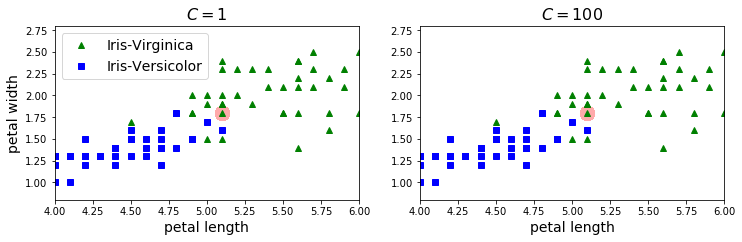

In [22]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

## 5.2 비선형 SVM 분류

다항 특성과 같은 특성을 더 추가한다.

이를 구현하려면 PolynomialFeatures 변환기와 StandardScaler, LinearSVC를 연결, Pipeline을 만든다.

In [ ]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

In [ ]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
plot_dataset(X, y, [-1.5, 2.5, -1.5, 1.5])
plt.show()


In [ ]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge")),
])

polynomial_svm_clf.fit(X, y)

In [ ]:
def plot_prediction(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    
plot_prediction(polynomial_svm_clf, [-1.5, 2.5, -1.5, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1.5, 1.5])

plt.show()

numpy.c_ = <numpy.lib.index_tricks.CClass object> [Link](https://numpy.org/doc/1.17/reference/generated/numpy.c_.html?highlight=c_#numpy.c_)
- Translates slice objects to concatenation along the second axis.

- This is short-hand for np.r_['-1,2,0', index expression], which is useful because of its common occurrence. In particular, arrays will be stacked along their last axis after being upgraded to at least 2-D with 1’s post-pended to the shape (column vectors made out of 1-D arrays).

numpy.meshgrid(\*xi, \*\*kwargs)[source](https://numpy.org/doc/1.17/reference/generated/numpy.meshgrid.html?highlight=meshgrid#numpy.meshgrid)
- Return coordinate matrices from coordinate vectors.

- Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays x1, x2,…, xn.

Returns:	
- X1, X2,…, XN : ndarray
  - For vectors x1, x2,…, ‘xn’ with lengths Ni=len(xi) , return (N1, N2, N3,...Nn) shaped arrays if indexing=’ij’ or (N2, N1, N3,...Nn) shaped arrays if indexing=’xy’ with the elements of xi repeated to fill the matrix along the first dimension for x1, the second for x2 and so on.
  
numpy.ravel(a, order='C')[source](https://numpy.org/doc/1.17/reference/generated/numpy.ravel.html#numpy.ravel)
- Return a contiguous flattened array.

- A 1-D array, containing the elements of the input, is returned. A copy is made only if needed.

Returns:	
- y : array_like
  - y is an array of the same subtype as a, with shape (a.size,). Note that matrices are special cased for backward compatibility, if a is a matrix, then y is a 1-D ndarray.

### 5.2.1 다항식 커널

커널 트릭 kernel trick

In [ ]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

In [ ]:
from sklearn.svm import SVC
poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])

poly100_kernel_svm_clf.fit(X, y)

In [ ]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_prediction(poly_kernel_svm_clf, [-1.5, 2.5, -1.5, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1.5, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_prediction(poly100_kernel_svm_clf, [-1.5, 2.5, -1.5, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1.5, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

matplotlib.pyplot.subplot(\*args, \*\*kwargs)[source](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html?highlight=subplot#matplotlib.pyplot.subplot)
- Add a subplot to the current figure.

- Wrapper of Figure.add_subplot with a difference in behavior explained in the notes section.

### 5.2.2 유사도 특성 추가

landmark와 얼마나 닮았는지 측정하는 similarity function유사도 함수로 계산한 특성을 추가.

가우시안 방사 기저 함수Radial Basis Function(RBF)를 유사도 함수로 정의

In [ ]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

numpy.linalg.norm(x, ord=None, axis=None, keepdims=False)[source](https://numpy.org/doc/1.17/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)
- Matrix or vector norm.

- This function is able to return one of eight different matrix norms, or one of an infinite number of vector norms (described below), depending on the value of the ord parameter.

Returns:	
- n : float or ndarray
  - Norm of the matrix or vector(s).

In [ ]:
gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk == 0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk == 1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$', xy=(X1D[3, 0], 0), xytext=(-0.5, 0.20),
             ha="center", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=18)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color="k")
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)

plt.axis([-0.1, 1.1, -0.1, 1.1])

matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, \*\*kwargs)[source](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.axhline.html?highlight=axhline#matplotlib.pyplot.axhline)
- Add a horizontal line across the axis.

matplotlib.pyplot.gca(\*\*kwargs)[source](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.gca.html?highlight=gca#matplotlib.pyplot.gca)
- Get the current Axes instance on the current figure matching the given keyword args, or create one.

Axes.get_yaxis(self)[source](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.get_yaxis.html?highlight=get_yaxis)
- Return the YAxis instance.

Axis.set_ticks(self, ticks, minor=False)[source](https://matplotlib.org/api/_as_gen/matplotlib.axis.Axis.set_ticks.html?highlight=set_ticks#matplotlib.axis.Axis.set_ticks)
- Set the locations of the tick marks from sequence ticks

matplotlib.pyplot.annotate(s, xy, \*args, \*\*kwargs)[source]
- Annotate the point xy with text text.

- In the simplest form, the text is placed at xy.

- Optionally, the text can be displayed in another position xytext. An arrow pointing from the text to the annotated point xy can then be added by defining arrowprops.

### 5.2.3 가우시안 RBF 커널

In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []

for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_prediction(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    
plt.show()

### 5.2.4 계산 복잡도

LinearSVC 
- liblinear 라이브러리 기바ㄴ
- 시간 복잡도: $O(m \times n)$

SVC 
- libsvm 라이브러리 기바ㄴ
- 시간 복잡도: $O(m^2 \times n) ~ O(m^3 \times n)$

## 5.3 SVM 회귀

회귀의 목표는 분류와 반대.

분류: 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한한 최대

회귀: 제하된 마진 오류 안에서 도로 안에 가능한 많은 샘플이 들어가도록 학습

ㄷㅗ로의 폭은 하이퍼파라미터 $\varepsilon\$으로 조절

선형 데이터셋을 임의로 만든다.

In [ ]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

X.shape, y.shape

In [ ]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)


def find_support_vector(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)


svm_reg1.support_ = find_support_vector(svm_reg1, X, y)
svm_reg2.support_ = find_support_vector(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])


def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_],
                s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)


plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate('',
             xy=(eps_x1, eps_y_pred),
             xycoords='data',
             xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
             textcoords='data',
             arrowprops={'arrowstyle': '<->', "linewidth": 1.5})
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)

plt.show()

비선형 데이터셋을 임의로 만든다.

In [ ]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [ ]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", gamma="auto", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", gamma="auto", degree=2, C=0.005, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

In [ ]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])

## 5.4 SVM 이론

### 5.4.1 결정 함수와 예측

In [26]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

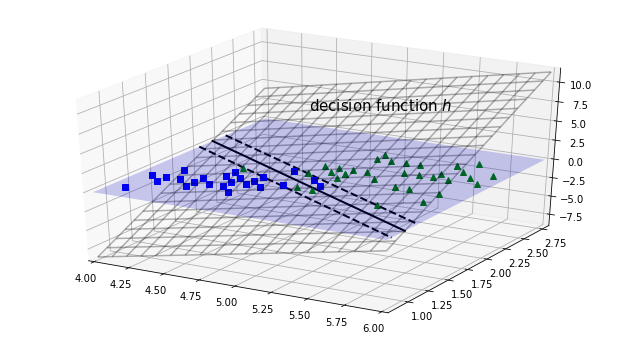

In [31]:
from mpl_toolkits.mplot3d import Axes3D


def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1]) - b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1]) - (b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1]) - (b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1), color="b",
                    alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "decision function $h$", fontsize=15)
    
    
fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection="3d")
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])
plt.show()